# 混合精度训练体验

[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/notebook/mindspore_mixed_precision.ipynb)

## 概述

神经网络训练的时候，数据和权重等各种参数一般使用单精度浮点数（float32）进行计算和存储。在采用复杂神经网络进行训练时，由于计算量的增加，机器的内存开销变得非常大。经常玩模型训练的人知道，内存资源的不足会导致训练的效率变低，简单说就是训练变慢，有没有什么比较好的方法，在不提升硬件资源的基础上加快训练呢？这次我们介绍其中一种方法--混合精度训练，说白了就是将参数取其一半长度进行计算，即使用半精度浮点数（float16）计算，这样就能节省一半内存开销。当然，为了保证模型的精度，不能把所有的计算参数都换成半精度。为了兼顾模型精度和训练效率，MindSpore在框架中设置了一个自动混合精度训练的功能，本次体验我们将使用ResNet-50网络进行训练，体验MindSpore混合精度训练和单精度训练的不同之处。

整体过程如下：

1. MindSpore混合精度训练的原理介绍。
2. 数据集准备。
3. 定义ResNet-50网络。
4. 定义`One_Step_Time`回调函数。
5. 定义训练网络（此处设置自动混合精度训练参数`amp_level`）。
6. 验证模型精度。
7. 混合精度训练和单精度训练的对比。

> 本文档适用于GPU和Ascend环境。

## MindSpore混合精度训练原理介绍

![image](https://gitee.com/mindspore/docs/raw/master/docs/mindspore/programming_guide/source_zh_cn/images/mix_precision.PNG)

1. 参数以FP32存储；
2. 正向计算过程中，遇到FP16算子，需要把算子输入和参数从FP32 `cast`成FP16进行计算；
3. 将Loss层设置为FP32进行计算；
4. 反向计算过程中，首先乘以Loss Scale值，避免反向梯度过小而产生下溢；
5. FP16参数参与梯度计算，其结果将被cast回FP32；
6. 除以`Loss scale`值，还原被放大的梯度；
7. 判断梯度是否存在溢出，如果溢出则跳过更新，否则优化器以FP32对原始参数进行更新。

从上可以理解(float16为半精度浮点数，float32为单精度浮点数)，MindSpore是将网络中的前向计算部分`cast`成半精度浮点数进行计算，以节省内存空间，提升性能，同时将`loss`值保持单精度浮点数进行计算和存储，`weight`使用半精度浮点数进行计算，单精度浮点数进行保存，通过这样操作即提升了训练效率，又保证了一定的模型精度，达到提升训练性能的目的。

## 数据集准备

在Jupyter Notebook中执行如下命令，下载并解压数据集CIFAR-10到指定位置。

In [ ]:
!wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz --no-check-certificate
!mkdir -p datasets
!tar -xzf cifar-10-binary.tar.gz -C datasets
!mkdir -p datasets/cifar-10-batches-bin/train datasets/cifar-10-batches-bin/test
!mv -f datasets/cifar-10-batches-bin/test_batch.bin datasets/cifar-10-batches-bin/test
!mv -f datasets/cifar-10-batches-bin/data_batch*.bin datasets/cifar-10-batches-bin/batches.meta.txt datasets/cifar-10-batches-bin/train

下载并解压的数据集文件的目录结构如下：

```text
./datasets/cifar-10-batches-bin
├── readme.html
├── test
│   └── test_batch.bin
└── train
    ├── batches.meta.txt
    ├── data_batch_1.bin
    ├── data_batch_2.bin
    ├── data_batch_3.bin
    ├── data_batch_4.bin
    └── data_batch_5.bin
```

### 数据增强

先将CIFAR-10的原始数据集可视化：

the cifar dataset size is : 50000
the tensor of image is: (32, 32, 3)


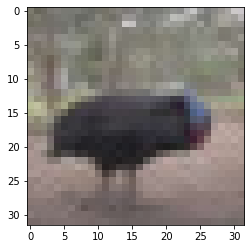

In [2]:
import mindspore.dataset as ds
import matplotlib.pyplot as plt
import numpy as np

train_path = "./datasets/cifar-10-batches-bin/train"
ds_train = ds.Cifar10Dataset(train_path, num_parallel_workers=8, shuffle=True)
print("the cifar dataset size is :", ds_train.get_dataset_size())
dict1 = ds_train.create_dict_iterator()
dict_data = next(dict1)
image = dict_data["image"].asnumpy()
print("the tensor of image is:", image.shape)
plt.imshow(np.array(image))
plt.show()

可以看到CIFAR-10总共包含了50000张32×32的彩色图片。

### 定义数据增强函数

定义数据集增强函数并将原始数据集进行增强，查看数据集增强后张量数据：

In [3]:
import os
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2

def create_dataset(dataset_path, do_train, repeat_num=1, batch_size=32):

    cifar_ds = ds.Cifar10Dataset(dataset_path, num_parallel_workers=8, shuffle=True)

    # define map operations
    trans = []
    if do_train:
        trans += [
            C.RandomCrop((32, 32), (4, 4, 4, 4)),
            C.RandomHorizontalFlip(prob=0.5)
        ]

    trans += [
        C.Resize((224, 224)),
        C.Rescale(1.0 / 255.0, 0.0),
        C.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        C.HWC2CHW()
    ]

    type_cast_op = C2.TypeCast(mstype.int32)

    cifar_ds = cifar_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=8)
    cifar_ds = cifar_ds.map(operations=trans, input_columns="image", num_parallel_workers=8)

    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    cifar_ds = cifar_ds.repeat(repeat_num)

    return cifar_ds


cifar_ds_train = create_dataset(train_path, do_train=True, repeat_num=1, batch_size=32)
print("the cifar dataset size is:", cifar_ds_train.get_dataset_size())
dict1 = cifar_ds_train.create_dict_iterator()
dict_data = next(dict1)
image = dict_data["image"].asnumpy()
print("the tensor of image is:", image.shape)

the cifar dataset size is: 1562
the tensor of image is: (32, 3, 224, 224)


cifar10通过数据增强后的，变成了一共有1562个batch，张量为(32,3,224,224)的数据集。

## 定义深度神经网络

本篇使用的MindSpore中的ResNet-50网络模型，下载相关的代码文件。

In [ ]:
import requests

url = "https://gitee.com/mindspore/docs/raw/master/docs/sample_code/resnet/resnet.py"
res = requests.get(url)
data = res.text

with open("resnet.py", "w", encoding="utf-8") as f:
    f.write(data)

下载后的文件在notebook的工作目录上，可以导出resnet50网络作为本案例的训练网络。

In [5]:
from resnet import resnet50

network = resnet50(batch_size=32, num_classes=10)

### 定义回调函数Time_per_Step来计算单步训练耗时

`Time_per_Step`用于计算每步训练的时间消耗情况，方便对比混合精度训练和单精度训练的性能区别。

In [6]:
from mindspore.train.callback import Callback
import time

class Time_per_Step(Callback):
    def step_begin(self, run_context):
        cb_params = run_context.original_args()
        cb_params.init_time = time.time()

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        one_step_time = (time.time() - cb_params.init_time) * 1000
        print(one_step_time, "ms")

## 定义训练网络

### 设置混合精度训练并执行训练

由于MindSpore已经添加了自动混合精度训练功能，我们这里操作起来非常方便，只需要在Model中添加参数`amp_level=O2`就完成了设置GPU模式下的混合精度训练设置。运行时，将会自动混合精度训练模型。

`amp_level`的参数详情：

`O0`：表示不做任何变化，即单精度训练，系统默认`O0`。

`O2`：表示将网络中的参数计算变为float16。适用于GPU环境。

`O3`：表示将网络中的参数计算变为float16，同时需要在Model中添加参数`keep_batchnorm_fp32=False`。适用于Ascend环境。

在`Model`中设置`amp_level=O2`后即可执行混合精度训练：

In [7]:
import os
from mindspore import context
import mindspore.nn as nn
from mindspore import Model
from mindspore.train.callback import LossMonitor, TimeMonitor
from mindspore.nn import SoftmaxCrossEntropyWithLogits


if __name__ == '__main__':

    context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

    model_path= "./models/ckpt/mindspore_mixed_precision"
    batch_size = 32
    epoch_size = 5
    ds_train_path = "./datasets/cifar-10-batches-bin/train"

    # clean up old run files before in Linux
    os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))
    # create dataset
    train_dataset = create_dataset(dataset_path=ds_train_path, do_train=True, repeat_num=1,
                                 batch_size=batch_size)

    # define net
    net = network

    # define
    step_size = train_dataset.get_dataset_size()
    lr = 0.01
    momentum = 0.9

    # define opt, loss, model
    loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    opt = nn.Momentum(network.trainable_params(), lr, momentum)
    model = Model(net, loss_fn=loss, optimizer=opt, metrics={'acc'},amp_level="O2")

    # define callbacks function
    steptime_cb = Time_per_Step()
    time_cb = TimeMonitor(data_size=step_size)
    loss_cb = LossMonitor()

    cb = [time_cb, loss_cb, steptime_cb]

    # train model
    model.train(epoch_size, train_dataset, callbacks=cb, dataset_sink_mode=True)

epoch: 1 step: 1562, loss is 0.907213
473624.29022789 ms
epoch time: 510142.338 ms, per step time: 326.596 ms
epoch: 2 step: 1562, loss is 1.1226461
456184.42153930664 ms
epoch time: 456187.154 ms, per step time: 292.053 ms
epoch: 3 step: 1562, loss is 0.76163876
456118.32642555237 ms
epoch time: 456120.763 ms, per step time: 292.011 ms
epoch: 4 step: 1562, loss is 0.68869615
456123.6324310303 ms
epoch time: 456126.046 ms, per step time: 292.014 ms
epoch: 5 step: 1562, loss is 0.8315078
456153.0604362488 ms
epoch time: 456155.529 ms, per step time: 292.033 ms


### 验证模型精度

使用模型进行精度验证可以得出以下代码。

In [8]:
# Eval model
eval_dataset_path = "./datasets/cifar-10-batches-bin/test"
eval_data = create_dataset(eval_dataset_path,do_train=False)
acc = model.eval(eval_data,dataset_sink_mode=True)
print("Accuracy:",acc)

Accuracy: {'acc': 0.7505008012820513}


## 对比不同网络下的混合精度训练和单精度训练的差别

由于篇幅原因，我们这里只展示了ResNet-50网络的混合精度训练情况。可以在主程序入口的Model中设置参数`amp_level = O0`进行单精度训练，训练完毕后，将结果进行对比，看看两者的情况，下面将我测试的情况做成表格如下。（训练时，笔者使用的GPU为Nvidia Tesla V100，不同的硬件对训练的效率影响较大，下述表格中的数据仅供参考）

|  网络 | 是否混合训练 | 单步训练时间 | epoch | Accuracy|
|:------  |:-----| :------- |:--- |:------|
|ResNet-50 |  否  | 100ms   |  5 |  0.8128245|
|ResNet-50 |  是  | 58ms   |  5 |  0.7717347|

经过多次测试，使用ResNet-50网络，CIFAR-10数据集，进行混合精度训练对整体的训练效率提升了60%左右，而最终模型的精度有少量降低，对于使用者来说，混合精度训练在提升训练效率上，是一个很好的选择。

当然，如果你想参考单步训练或者手动设置混合精度训练，可以参考官网教程<https://www.mindspore.cn/docs/programming_guide/zh-CN/master/enable_mixed_precision.html>。

## 总结

本次体验我们尝试了在ResNet-50网络中使用混合精度来进行模型训练，并对比了单精度下的训练过程，了解到了混合精度训练的原理和对模型训练的提升效果。